# Tutorial

In this tutorial, we'll briefly show how to use vivi and what type of analysis you can make with this framework

## 0. Installation

As for now, vivi does not have an instalation option, you just need to copy the files for your directory and include the functions in your julia code/notebook.

But before including the code, make sure that all dependencies are installed first:
* **JuMP** : A framework to write optimization problems
* **GLPK** : A linear optimization solver
* **Plots** : Plotting functions
* **DelimitedFiles** : Export ploting data
* **Graphs** : To construct graphs
* **GraphRecipes** : To plot graphs

To install a package you just need to run two lines of code, for instance to install JuMP:
    
    using Pkg
    
    Pkg.add(JuMP)
    
You just need to repeat the last line changing the name of the package to install other dependencies, e.g.:

    Pkg.add(GLPK)

Now let's include the core function and data structures in our notebook:

In [1]:
# Including functions
include("../src/vivi.jl")

vivi_cc (generic function with 3 methods)

## 1. Data structures

In vivi, there are three main data structures:
1. **Resources** : a good that is consumed/produced from a process besides heat
2. **Heat** : a heat transfer that demands/supplies energy 
3. **Tech** : a process/utility system that convert resources and/or supply/demands heat

### 1.1 Resources
A resource can be created following the syntax:

    resource = Resource(type,amount,unit,[value 1, value 2, ..., value n])
    
* type = is the resource name that identifies it
* amount = quantity of the resource available, consumed or produced    
* unit = the unit type of "amount"
* [value 1, value 2, ..., value n] : is array of specific values for this resource. For instance: [energy/mass , price/mass, carbon/mass]

**OBS** : If a resource is flexible (e.g. electricity imported from the grid), you have to set the amount as *Inf*, e.g.:
    
    power = Resource("power",Inf,"kW",[1])

### 1.2 Heat
A heat transfer can be created as:

    heat = HeatStruct(h,Ts,Tt)
    
* h : energy transfer rate (preferably in kW)
* Ts : source temperature in Kelvin
* Tt : target tempreature in Kelvin

Example, a gas heating from 100 °C to 200 °C that requires 100 kW of energy:

    gas_heat = HeatStruct(100, 373.2, 473.2)
    
**OBS** : You can use any unit for "h" as long as it is the **same for all** HeatStructs in your code

### 1.3 Tech

A technology can be included in the code as:

    tech = Tech(type,in,out,heat)
    
* type : is the name of the tech
* in : is an array of *Resource* that are consumed by tech
* out : is an array of *Resource* that are produced by tech
* heat : is an array of *HeatStruct* that represent the heat transfers of tech

**OBS**: if a tech does not have in, out or heat, just include a empty array ([]), e.g.: 

    cooling_tower = Tech("CT",ct_in,[],ct_heat)

### 1.4 EXAMPLE: Solid oxide cell electrolysis
Let's consider an problem that consists of a **solid oxide electrolyzer** (SOEC) that converts **steam** into **hydrogen**, but requires **heat/cooling** and **power** to do it. Based on thermodynamic models and experiments, we know that:

![SOEC image](soec.svg)

1. SOEC requires **0.06165 kg/s of steam (1.12 bar)** and **620.20 kW of power**

In [2]:
soec_in = [Resource("steam_1.12bar",0.06165,"kg/s",[1]),
           Resource("power",620.20,"kW",[1])]

2-element Vector{Resource}:
 Resource("steam_1.12bar", 0.06165, "kg/s", Real[1])
 Resource("power", 620.2, "kW", Real[1])

2. SOEC produces **0.005 kg/s of hydrogen**

In [3]:
soec_out = [Resource("h2",0.005,"kg/s",[1])]

1-element Vector{Resource}:
 Resource("h2", 0.005, "kg/s", Real[1])

3. And has a number of **heat transfers** that requires/supplies energy

In [4]:
soec_heat = [HeatStruct(84.9, 376, 1023),   # Steam superheating
             HeatStruct(66.4, 1022, 473),   # O2 cooling
             HeatStruct(6.3, 481, 313),     # Excess O2 cooling
             HeatStruct(43.2, 481, 1023),   # Reheating O2 recirculation 
             HeatStruct(73.5, 1022, 343),   # Steam/H2 cooling
             HeatStruct(38.8, 343, 313)]    # Steam condensation

6-element Vector{HeatStruct}:
 HeatStruct(84.9, 376.0, 1023.0)
 HeatStruct(66.4, 1022.0, 473.0)
 HeatStruct(6.3, 481.0, 313.0)
 HeatStruct(43.2, 481.0, 1023.0)
 HeatStruct(73.5, 1022.0, 343.0)
 HeatStruct(38.8, 343.0, 313.0)

Based on this info that we collected from industry/models/experiments, we can than create a Tech to represent SOEC:

In [5]:
soec = Tech("soec",soec_in,soec_out,soec_heat)

Tech("soec", Any[Resource("steam_1.12bar", 0.06165, "kg/s", Real[1]), Resource("power", 620.2, "kW", Real[1])], Any[Resource("h2", 0.005, "kg/s", Real[1])], HeatStruct[HeatStruct(84.9, 376.0, 1023.0), HeatStruct(66.4, 1022.0, 473.0), HeatStruct(6.3, 481.0, 313.0), HeatStruct(43.2, 481.0, 1023.0), HeatStruct(73.5, 1022.0, 343.0), HeatStruct(38.8, 343.0, 313.0)])

We can visualize the Tech as Graph just to make sure that the main information was correctly passed to Julia.

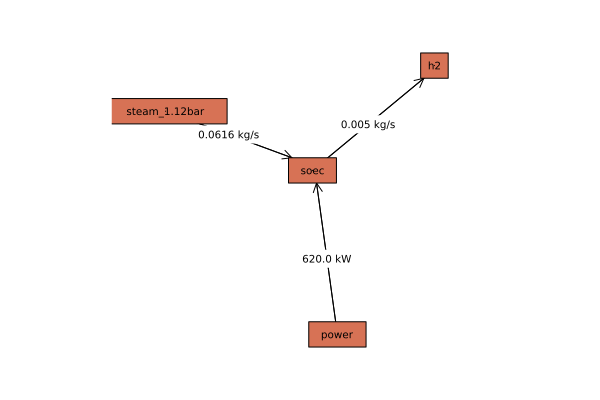

In [6]:
vivi_graph(soec)

Here we are assuming that saturated steam (and not water) is supplied for the SOEC. Differently from power, we usually can't get steam directily from the market, therefore we will need to integrate the SOEC with other Tech that can supply this resource (e.g. steam generator) in the future. 

Let's have a look in the heat transfers by using pinch analysis. Plotting the composite curves, we have:

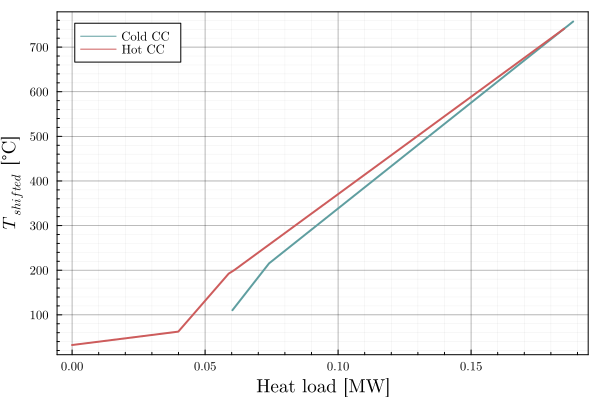

In [7]:
vivi_cc(soec)

Plotting the grand composite curve, we have:

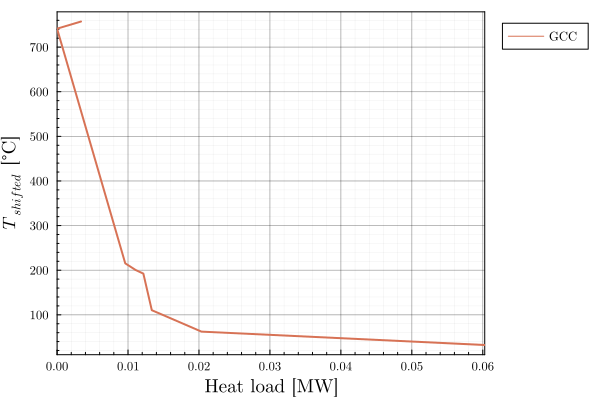

In [8]:
vivi_gcc(soec)

There are some observations that can be made based on the CC and GCC plots:
1. The SOEC tech requires external heat at high temperatures (> 700 °C)
2. There is a excess heat available for energy integration
3. However most of it is at low temperatures (< 100 °C) which usually are not valuable and require a cooling system (e.g. cooling tower)

## 2. Problem

vivi helps to structurate a linear programming optimization problem that aims to answer the question:

> Given a specific resource input and/or product demand, what is the combination of techologies that optimize the net value of operation (value of products - value of consumptions)?

OBS: Note that this means that vivi (as for today) does not considers the CAPEX of each techology in the optimization process.

Therefore, a problem depends on a set of Resources and Techs, which are separated into two groups each

    problem = Problem(inputs,processes,outputs,utilities)

* inputs : Resources that can be externally supplied (e.g., power, biomass, fuel, etc.)
* processes : the main Techs that convert resources (e.g., pyrolysis, electrolysis, fuel synthesis)
* outputs : Resources that can be exported to other stakeholders (e.g., power, biofuel, hydrogen)
* utilities : auxiliary Techs that supply heating/cooling or others inputs (e.g. steam generation, cooling tower, Rankine cycle)

It is important to emphasize that:
* inputs and outputs define the boundary conditions of the problem by setting what it is allowed to be imported and exported from the "market"/environment
* the difference between processes and utils are **subjective** and only affect the pinch analysis plots

A problem than can be solved by calling the optimization routine:

    answer = vivi(problem)

### 2.1 EXAMPLE: Solid oxide cell electrolysis and utilities

Imagine that we would like to know how much **power** would be necessary to create **1 kg/s of hydrogen**. Thus the **input** of our problem is power:

In [9]:
# Creating a variable power resource
power = Resource("power",Inf,"kW",[1])
# OBS: note that the amount of power is Inf in this case, since it is variable at this point

inputs = [power]

1-element Vector{Resource}:
 Resource("power", Inf, "kW", Real[1])

And the **output** is 1 kg/s of hydrogen

In [10]:
# Creating a variable power resource
lhv_h2 = 119.96E3 # kJ/kg
h2 = Resource("h2",1,"kg/s",[lhv_h2])
# OBS: note that we have to include a conversion factor to make inputs and outputs in the same basis, in this case energy (kW)

outputs = [h2]

1-element Vector{Resource}:
 Resource("h2", 1, "kg/s", Real[119960.0])

Although we know how much power is consumed in a SOEC for a specific operating condition (previous example), our information assumes that **steam**, **external heat** and **cooling** are free. Thus we should include additional Techs as utils to supply these goods for our main process "soec":

In [11]:
# Steam generation - 1.12 bar
steam_1bar_in = [Resource("power",0.017,"kW",[1])]
steam_1bar_out = [Resource("steam_1.12bar",1,"kg/s",[1])]
steam_1bar_heat = [HeatStruct(326.1,298,376),
                   HeatStruct(2249,376,377)]
sg_1bar = Tech("sg_1bar",steam_1bar_in,steam_1bar_out,steam_1bar_heat)

# Eletric heating
eh_in = [Resource("power",1.0,"kW",[1])]
eh_heat = [HeatStruct(1.0,1273,1272)]
eh = Tech("EH",eh_in,[],eh_heat)

# Cooling tower
ct_in = [Resource("power",0,"kW",[1])]
ct_heat = [HeatStruct(1.0,298,45+273)]
ct = Tech("CT",ct_in,[],ct_heat)

# Utilities
utilities = [sg_1bar,eh,ct]

3-element Vector{Tech}:
 Tech("sg_1bar", Any[Resource("power", 0.017, "kW", Real[1])], Any[Resource("steam_1.12bar", 1, "kg/s", Real[1])], HeatStruct[HeatStruct(326.1, 298.0, 376.0), HeatStruct(2249.0, 376.0, 377.0)])
 Tech("EH", Any[Resource("power", 1.0, "kW", Real[1])], Any[], HeatStruct[HeatStruct(1.0, 1273.0, 1272.0)])
 Tech("CT", Any[Resource("power", 0, "kW", Real[1])], Any[], HeatStruct[HeatStruct(1.0, 298.0, 318.0)])

Now, we just need to ask vivi to solve the problem for us:

In [12]:
problem = Problem(inputs,[soec],outputs,utilities)
answer = vivi(problem)

* Solver : GLPK

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "Solution is optimal"

* Candidate solution
  Objective value      : -3.08897e+04
  Objective bound      : Inf
  Dual objective value : -3.08897e+04

* Work counters
  Solve time (sec)   : 0.00000e+00

 Tech      | Size factor
 soec      | 200.0
 sg_1bar   | 12.33
 EH        | 26809.51646
 CT        | 6438.53346


Problem(Any[Resource("power", 150849.72607153884, "kW", Real[1])], Any[Tech("soec", Any[Resource("steam_1.12bar", 12.33, "kg/s", Real[1]), Resource("power", 124040.00000000001, "kW", Real[1])], Any[Resource("h2", 1.0, "kg/s", Real[1])], HeatStruct[HeatStruct(16980.0, 376.0, 1023.0), HeatStruct(13280.000000000002, 1022.0, 473.0), HeatStruct(1260.0, 481.0, 313.0), HeatStruct(8640.0, 481.0, 1023.0), HeatStruct(14700.0, 1022.0, 343.0), HeatStruct(7759.999999999999, 343.0, 313.0)])], Any[Resource("h2", 1.0000000000000029, "kg/s", Real[119960.0])], Any[Tech("sg_1bar", Any[Resource("power", 0.20961000000000002, "kW", Real[1])], Any[Resource("steam_1.12bar", 12.33, "kg/s", Real[1])], HeatStruct[HeatStruct(4020.813, 298.0, 376.0), HeatStruct(27730.170000000002, 376.0, 377.0)]), Tech("EH", Any[Resource("power", 26809.51646, "kW", Real[1])], Any[], HeatStruct[HeatStruct(26809.51646, 1273.0, 1272.0)]), Tech("CT", Any[Resource("power", 0.0, "kW", Real[1])], Any[], HeatStruct[HeatStruct(6438.53346, 

vivi optimization has calculated the size factors for each Tech in order to maximize revenues, in this case the net energy of outpus - inputs. For instance, in order to achieve the hydrogen production we will need a 26809x larger system of eletric heating. You can examinate the answers to get the exact numbers of resources consumption and production.

In [13]:
# Calculating the efficiency
h2_energy = answer.outputs[1].amount*answer.outputs[1].value[1]
power_consumption = answer.inputs[1].amount

eff = h2_energy/power_consumption
println("Energy efficiency = $(eff*100) %")

Energy efficiency = 79.52284907903024 %


Another way to visualize is to plot the corresponding graph for the answer (with lots of techs it can be hard to read the information). 

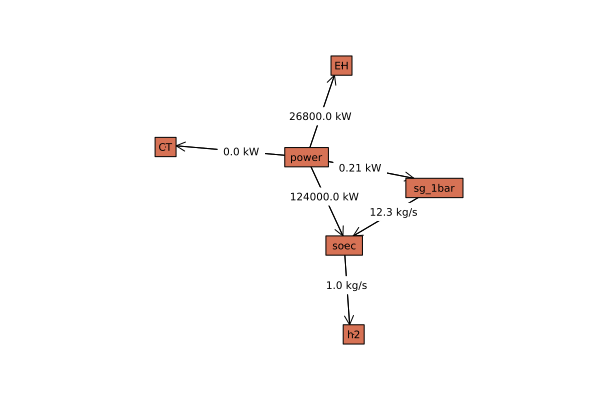

In [14]:
vivi_graph(answer)

You can also plot the pinch analysis results. For instance:

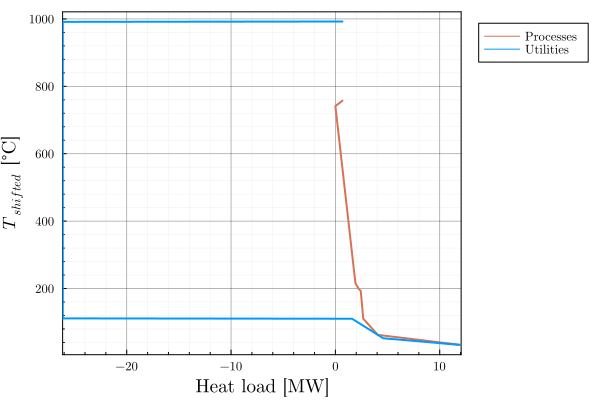

In [15]:
# Integrated composite curve
vivi_icc(answer)

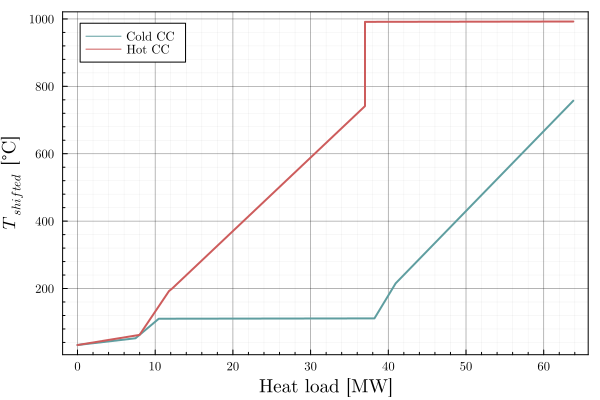

In [16]:
# Composite curve
vivi_cc(answer)

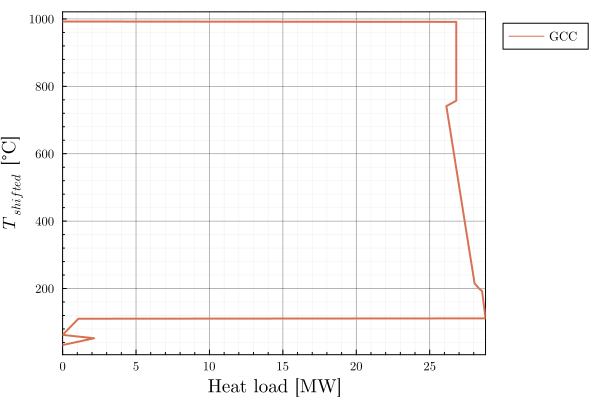

In [17]:
# Grand composite curve
vivi_gcc(answer)

The pinch analysis shows that a lot of heat has to be supplied from eletric heating mostly because of the steam generation. Thus, if steam could be generated with excess heat of another process, the overall efficiency of our SOEC system could be higher (less external energy consumption). This can be evaluated by including these additional processes as new Techs in the Problem and solving it again.